# Siamese

Source: https://keras.io/examples/mnist_siamese/

In [1]:
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import ipyvolume as ipv
import pathlib
import math

import sys
sys.path.append("..") 
from cryoem.projections import RotationMatrix

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops

In [2]:
import seaborn as sns; sns.set(style="white", color_codes=True)

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6716096287489387221
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17578056280754500140
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13728044703936310123
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16629091556857712410
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8382438525152096831
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memor

## Read data 

In [4]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
num_projections = 5000
dir_name = "../data/"
projections_filename = f"5j0n_ProjectionsAngles_ProjNber{num_projections}_AngCoverage{angle_ranges}_AngShift{angle_shift}"


# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

X, y = data['Projections'], data['Angles']
print(f"{X.shape[0]} projections of images with dimension {X.shape[1:]} pixels")
print(f"{y.shape[0]} sets of {y.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [5]:
# plot coverage
all_vectors = RotationMatrix(y)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/{angle_ranges}.html")
ipv.show()

## Distances


#### Angle Distance

In [6]:
def euler2quaternion(angles):
    """
    Document: https://www.sedris.org/wg8home/Documents/WG80485.pdf
    
    Tait-Bryan angles:
        Quaternion implements 3 rotations along z-y-x axis. 
        We compose them to get the final (single) rotation.
    Euler angles:
        Quaternion implements 3 rotations along z-y-z axis.
    General:
        q = xi + yj + zk + w
    Stored as 4D:
        [x, y, z, w].T
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def quaternion2euler(quaternions):
    """https://github.com/tensorflow/graphics/blob/master/tensorflow_graphics/geometry/transformation/euler.py"""
    def general_case(r02, r12, r20, r21, r22, eps_addition):
        """Handles the general case."""
#         theta_y = -tf.asin(r20)
#         sign_cos_theta_y = safe_ops.nonzero_sign(tf.cos(theta_y))
#         r00 = safe_ops.nonzero_sign(r00) * eps_addition + r00
#         r22 = safe_ops.nonzero_sign(r22) * eps_addition + r22
#         theta_z = tf.atan2(r10 * sign_cos_theta_y, r00 * sign_cos_theta_y)
#         theta_x = tf.atan2(r21 * sign_cos_theta_y, r22 * sign_cos_theta_y)
#         return tf.stack((theta_x, theta_y, theta_z), axis=-1)
        theta_y = tf.acos(r22)
        # TODO: check this >>>
        sign_sin_theta_y = safe_ops.nonzero_sign(tf.sin(theta_y))
        
        r02 = safe_ops.nonzero_sign(r02) * eps_addition + r02
        r22 = safe_ops.nonzero_sign(r22) * eps_addition + r22
        theta_z0 = tf.atan2(r12 * sign_sin_theta_y, r02 * sign_sin_theta_y)
        theta_z1 = tf.atan2(r21 * sign_sin_theta_y, -r20 * sign_sin_theta_y)
        return tf.stack((theta_z0, theta_y, theta_z1), axis=-1)

    def gimbal_lock(r22, r11, r10, eps_addition):
        """Handles Gimbal locks."""
#         sign_r20 = safe_ops.nonzero_sign(r20)
#         r02 = safe_ops.nonzero_sign(r02) * eps_addition + r02
#         theta_x = tf.atan2(-sign_r20 * r01, -sign_r20 * r02)
#         theta_y = -sign_r20 * tf.constant(math.pi / 2.0, dtype=r20.dtype)
#         theta_z = tf.zeros_like(theta_x)
#         angles = tf.stack((theta_x, theta_y, theta_z), axis=-1)
#         return angles
        sign_r22 = safe_ops.nonzero_sign(r22)
        r11 = safe_ops.nonzero_sign(r11) * eps_addition + r11
        theta_z0 = tf.atan2(-sign_r22 * r10, -sign_r22 * r11)  # TODO: was -
        theta_y = tf.constant(math.pi/2.0, dtype=r20.dtype) - sign_r22 * tf.constant(math.pi/2.0, dtype=r20.dtype)
        theta_z1 = tf.zeros_like(theta_z0)
        angles = tf.stack((theta_z0, theta_y, theta_z1), axis=-1)
        return angles

    with tf.compat.v1.name_scope(None, "euler_from_quaternion", [quaternions]):
        quaternions = tf.convert_to_tensor(value=quaternions)

        shape.check_static(
            tensor=quaternions,
            tensor_name="quaternions",
            has_dim_equals=(-1, 4))

        x, y, z, w = tf.unstack(quaternions, axis=-1)
        tx = safe_ops.safe_shrink(2.0 * x, -2.0, 2.0, True)
        ty = safe_ops.safe_shrink(2.0 * y, -2.0, 2.0, True)
        tz = safe_ops.safe_shrink(2.0 * z, -2.0, 2.0, True)
        twx = tx * w
        twy = ty * w
        twz = tz * w
        txx = tx * x
        txy = ty * x
        txz = tz * x
        tyy = ty * y
        tyz = tz * y
        tzz = tz * z

        # The following is clipped due to numerical instabilities that can take some
        # enties outside the [-1;1] range.
        r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
        r10 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
        r21 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)
        r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        r20 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)
        r01 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
        r02 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)
        
        r12 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)
        r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
        eps_addition = asserts.select_eps_for_addition(quaternions.dtype)
        general_solution = general_case(r02, r12, r20, r21, r22, eps_addition)
        gimbal_solution = gimbal_lock(r22, r11, r10, eps_addition)
        
        # The general solution is unstable close to the Gimbal lock, and the gimbal
        # solution is not toooff in these cases.
        is_gimbal = tf.less(tf.abs(tf.abs(r22) - 1.0), 1.0e-6)
        gimbal_mask = tf.stack((is_gimbal, is_gimbal, is_gimbal), axis=-1)
        
        return tf.compat.v1.where(gimbal_mask, gimbal_solution, general_solution)        
    
def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [7]:
# sanity-check
e_i = np.array([1.5, 1.5, 1.5])
print(e_i)
q = euler2quaternion(e_i).numpy()
print(q)
e = quaternion2euler(q).numpy()
print(e)
q2 = euler2quaternion(e).numpy()
print(q2)

[1.5 1.5 1.5]
[0.         0.68163876 0.72985598 0.05175762]
[1.5 1.5 1.5]
[2.22044605e-16 6.81638760e-01 7.29855978e-01 5.17576231e-02]


In [8]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

#### Projection Distance [basic: Euclidean]

In [9]:
# def d_p(p1, p2):
#     # (learned) distance between two images.
#     # for now, Euclid dist
#     p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
#     p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

#     if len(p1.shape) > 1:
#         dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
#     else:
#         dist = tf.norm(p1-p2, ord='euclidean')

#     return dist

In [10]:
# assert tf.reduce_mean(d_p(X[0:3], X[0:3])) < 1e-7

---

## kNN of the Projections

In [11]:
k = 5

In [12]:
def get_knn_output(k):
    start_time = time()

    _X = np.reshape(X, (X.shape[0], -1))
    
    name = projections_filename.split('/')[-1]
    if not os.path.exists(f'data/knn{k}_{name}_distances.npy'):
        nbrs = NearestNeighbors(n_neighbors=k, metric=d_p, algorithm='ball_tree', n_jobs=-1).fit(_X)
        distances_p, indices_p = nbrs.kneighbors(_X)
        A_p = nbrs.kneighbors_graph(_X).toarray()

        try:
            np.save(f'data/knn{k}_{name}_indices', indices_p)         # Indices of the nearest points in the population matrix
            np.save(f'data/knn{k}_{name}_distances', distances_p)     # Array representing the lengths to points
            np.save(f'data/knn{k}_{name}_A', A_p)                     # Sparse graph showing the connections between neighboring points
        except:
            pass
        print(f"--- {time() - start_time} seconds ---")
    
    else:
        indices_p     = np.load(f'data/knn{k}_{name}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
        distances_p   = np.load(f'data/knn{k}_{name}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
        A_p           = np.load(f'data/knn{k}_{name}_A.npy')           # shape: NUM_IMGS, NUM_IMGS

    
    return indices_p, distances_p, A_p 

In [13]:
# --- 23594.572999954224 seconds ---
indices_p, distances_p, A_p = get_knn_output(k=k)

In [14]:
np.max(distances_p)

63.95002548806251

---

# 1. Metric Learning

## Prepare for training

In [15]:
def sample_pairs(projections, num_pairs, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.choice(projections, size=num_pairs))
        idx2 = list(np.random.choice(projections, size=num_pairs))
    
    elif style=="knn":
        idx1 = list(np.random.choice(projections, size=num_pairs))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.choice(projections, size=num_pairs))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
        idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

In [16]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def create_pairs(x, y, indices, num_pairs):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    
    # Sample some pairs.
    idx1, idx2 = sample_pairs(projections=indices, num_pairs=num_pairs, style="random", k=k)
    
    for z1, z2 in zip(idx1, idx2):
        pairs += [[x[z1], x[z2]]]
        labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)

In [17]:
EPOCHS = 500
BATCH_SIZE = 256
NUM_PROJECTIONS = 5000

LR = 0.001
CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)

In [18]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [19]:
len(train_idx), len(val_idx), len(test_idx)

(2512, 838, 1650)

In [20]:
len(train_idx)**2, len(val_idx)**2, len(test_idx)**2

(6310144, 702244, 2722500)

In [21]:
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=60000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

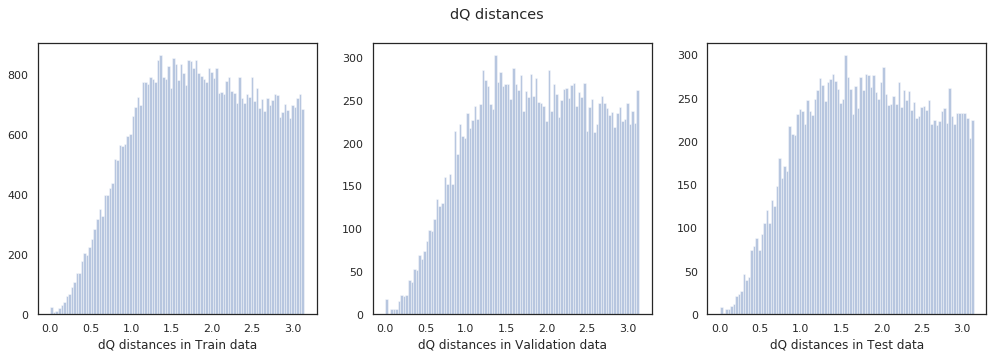

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))
plt.suptitle("dQ distances")

sns.set(style="white", color_codes=True)
sns.set(style="whitegrid")
sns.distplot(tr_y, kde=False, bins=100, ax=axs[0], axlabel="dQ distances in Train data", color="b")
sns.distplot(val_y, kde=False, bins=100, ax=axs[1], axlabel="dQ distances in Validation data", color="b")
sns.distplot(te_y, kde=False, bins=100, ax=axs[2], axlabel="dQ distances in Test data", color="b");

In [23]:
input_shape = val_pairs[:, 0].shape[1:]
print(f"Input images shape {input_shape}")

Input images shape (116, 116, 1)


### Train the model

In [24]:

# network definition
base_network = create_base_network(input_shape)


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)


# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)



distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])



model = Model([input_a, input_b], distance)


# train
#optimizer = RMSprop()
optimizer = Adam(learning_rate=LR)

model.compile(loss=mse, optimizer=optimizer, metrics=['mae'])

model.summary()


# Create a callback that saves the model's weights
backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
                              save_weights_only=True,
                              verbose=1)

history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y),
                  callbacks=[backup_callback])

model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
model.save(model_filename) 
print(f"Model saved to: {model_filename}")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

Epoch 25/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0467 - mae: 0.1725
Epoch 00025: saving model to training/20191224_020240
60000/60000 [==============================] - 124s 2ms/sample - loss: 0.0467 - mae: 0.1726 - val_loss: 0.0711 - val_mae: 0.2124
Epoch 26/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0456 - mae: 0.1705
Epoch 00026: saving model to training/20191224_020240
60000/60000 [==============================] - 124s 2ms/sample - loss: 0.0456 - mae: 0.1705 - val_loss: 0.0908 - val_mae: 0.2275
Epoch 27/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0462 - mae: 0.1716
Epoch 00027: saving model to training/20191224_020240
60000/60000 [==============================] - 125s 2ms/sample - loss: 0.0462 - mae: 0.1716 - val_loss: 0.0830 - val_mae: 0.2187
Epoch 28/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0448 - mae: 0.1692
Epoch 00028: saving model to training/20191224_020240
60000/600

59904/60000 [============================>.] - ETA: 0s - loss: 0.0386 - mae: 0.1550
Epoch 00083: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0386 - mae: 0.1550 - val_loss: 0.0770 - val_mae: 0.2098
Epoch 84/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0383 - mae: 0.1549
Epoch 00084: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0383 - mae: 0.1548 - val_loss: 0.0712 - val_mae: 0.2075
Epoch 85/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0380 - mae: 0.1539
Epoch 00085: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0380 - mae: 0.1539 - val_loss: 0.0727 - val_mae: 0.2076
Epoch 86/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0381 - mae: 0.1544
Epoch 00086: saving model to training/20191224_020240
60000/60000 [=========

59904/60000 [============================>.] - ETA: 0s - loss: 0.0362 - mae: 0.1501
Epoch 00141: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0363 - mae: 0.1501 - val_loss: 0.0716 - val_mae: 0.2061
Epoch 142/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0364 - mae: 0.1503
Epoch 00142: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0364 - mae: 0.1503 - val_loss: 0.0711 - val_mae: 0.2056
Epoch 143/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0363 - mae: 0.1503
Epoch 00143: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0364 - mae: 0.1503 - val_loss: 0.0722 - val_mae: 0.2067
Epoch 144/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0365 - mae: 0.1508
Epoch 00144: saving model to training/20191224_020240
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0356 - mae: 0.1487
Epoch 00199: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0356 - mae: 0.1487 - val_loss: 0.0722 - val_mae: 0.2071
Epoch 200/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0355 - mae: 0.1485
Epoch 00200: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0355 - mae: 0.1486 - val_loss: 0.0699 - val_mae: 0.2068
Epoch 201/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0356 - mae: 0.1487
Epoch 00201: saving model to training/20191224_020240
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.0356 - mae: 0.1487 - val_loss: 0.0792 - val_mae: 0.2121
Epoch 202/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0354 - mae: 0.1482
Epoch 00202: saving model to training/20191224_020240
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0347 - mae: 0.1467
Epoch 00257: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0348 - mae: 0.1467 - val_loss: 0.0731 - val_mae: 0.2081
Epoch 258/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0352 - mae: 0.1476
Epoch 00258: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0352 - mae: 0.1476 - val_loss: 0.0718 - val_mae: 0.2080
Epoch 259/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0349 - mae: 0.1473
Epoch 00259: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0349 - mae: 0.1473 - val_loss: 0.0788 - val_mae: 0.2141
Epoch 260/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0350 - mae: 0.1472
Epoch 00260: saving model to training/20191224_020240
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0345 - mae: 0.1463
Epoch 00315: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0346 - mae: 0.1463 - val_loss: 0.0877 - val_mae: 0.2207
Epoch 316/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0347 - mae: 0.1463
Epoch 00316: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0346 - mae: 0.1462 - val_loss: 0.0740 - val_mae: 0.2087
Epoch 317/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0346 - mae: 0.1465
Epoch 00317: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0346 - mae: 0.1465 - val_loss: 0.0785 - val_mae: 0.2132
Epoch 318/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0348 - mae: 0.1468
Epoch 00318: saving model to training/20191224_020240
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0344 - mae: 0.1460
Epoch 00374: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0344 - mae: 0.1460 - val_loss: 0.0821 - val_mae: 0.2160
Epoch 375/500
 6400/60000 [==>...........................] - ETA: 1:38 - loss: 0.0324 - mae: 0.1417
Epoch 00375: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0344 - mae: 0.1461 - val_loss: 0.0814 - val_mae: 0.2152
Epoch 376/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0343 - mae: 0.1457
Epoch 00376: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0343 - mae: 0.1457 - val_loss: 0.0801 - val_mae: 0.2148
Epoch 377/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0344 - mae: 0.1461
Epoch 00377: saving model to training/20191224_020240
60000/60000 [====

59904/60000 [============================>.] - ETA: 0s - loss: 0.0342 - mae: 0.1453
Epoch 00433: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0342 - mae: 0.1453 - val_loss: 0.0780 - val_mae: 0.2132
Epoch 434/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0340 - mae: 0.1451
Epoch 00434: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0340 - mae: 0.1452 - val_loss: 0.0830 - val_mae: 0.2163
Epoch 435/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0340 - mae: 0.1451
Epoch 00435: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0340 - mae: 0.1451 - val_loss: 0.0757 - val_mae: 0.2112
Epoch 436/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0342 - mae: 0.1455
Epoch 00436: saving model to training/20191224_020240
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0341 - mae: 0.1452
Epoch 00491: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0341 - mae: 0.1453 - val_loss: 0.0751 - val_mae: 0.2101
Epoch 492/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0339 - mae: 0.1449
Epoch 00492: saving model to training/20191224_020240
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.0339 - mae: 0.1449 - val_loss: 0.0908 - val_mae: 0.2243
Epoch 493/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0342 - mae: 0.1454
Epoch 00493: saving model to training/20191224_020240
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.0342 - mae: 0.1454 - val_loss: 0.0732 - val_mae: 0.2088
Epoch 494/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0341 - mae: 0.1453
Epoch 00494: saving model to training/20191224_020240
60000/60000 [======

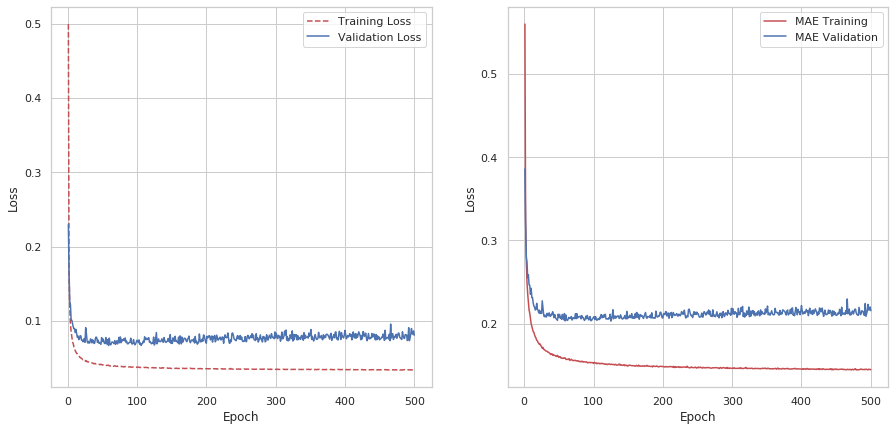

In [25]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']
maes = history.history['mae']
val_maes = history.history['val_mae']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, maes, 'r-', label='MAE Training')
ax2.plot(epoch_count, val_maes, 'b-', label='MAE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

### (Or) Read model checkpoint

In [32]:
# stop here, change file

In [24]:
#model_filename = "training/20191218_023743.h5"
model_filename = "training/20191224_191337.h5"

In [25]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [26]:
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_val_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]])

In [27]:
def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 0.6546005606651306
true:      0.6907155513763428
mse:       0.0013042925857007504
mae:       0.03611499071121216


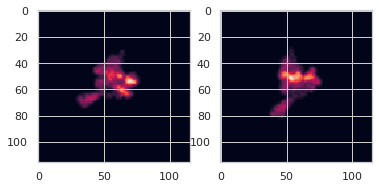

In [28]:
plot_train_results(1)

--- Validation Set ---
predicted: 1.4768999814987183
true:      1.552209734916687
mse:       0.005671558901667595
mae:       0.07530975341796875


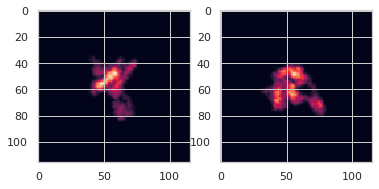

In [29]:
plot_validation_results(0)

---

## dP/dQ plot

### dP/dQ on Training

In [30]:
import pandas as pd
import seaborn as sns; sns.set(style="white", color_codes=True)

In [31]:
# Creating the dataframe for SNS plot
data = {"d_Q" : tr_y.numpy(),
        "d_P" : y_tr_pred.T[0]}
df1 = pd.DataFrame(data=data)

# Creating the dataframe for SNS plot
data = {"d_Q" : val_y.numpy(),
        "d_P" : y_val_pred.T[0]}
df2 = pd.DataFrame(data=data)

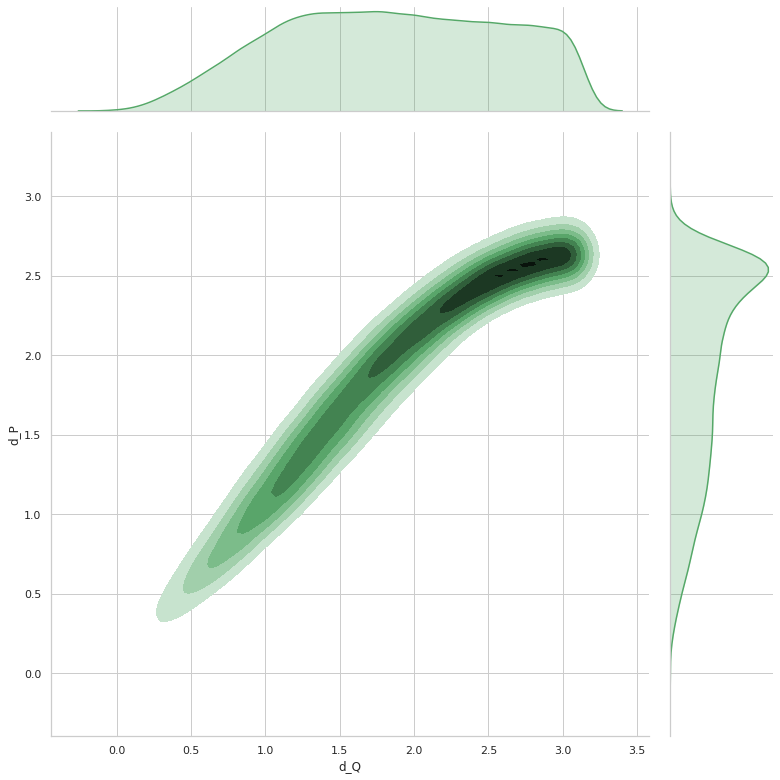

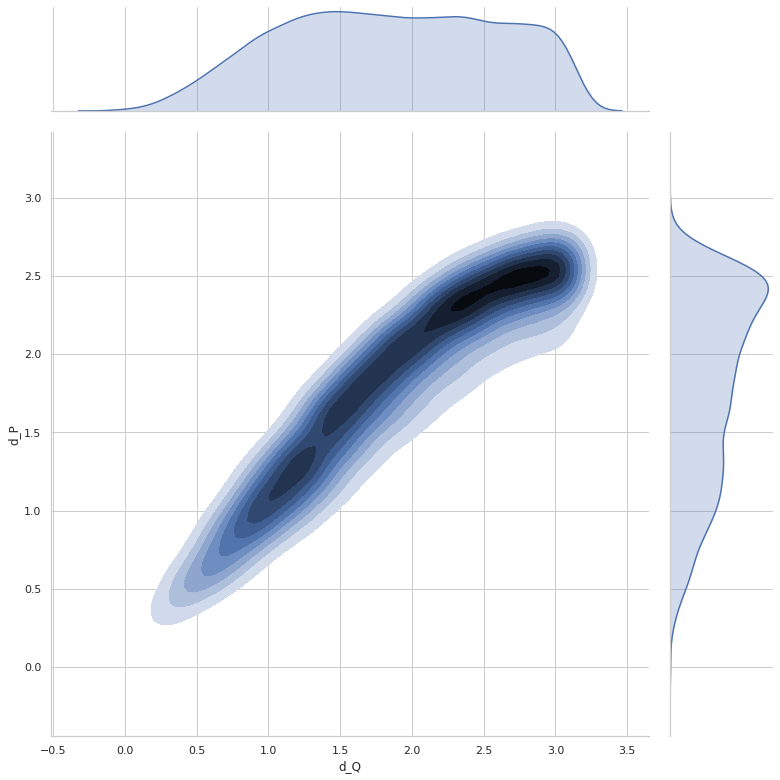

In [32]:
sns.set(style="white", color_codes=True)
sns.set(style="whitegrid")
JG1 = sns.jointplot(x="d_Q", y="d_P", data=df1, kind="kde", color="g", height=11,joint_kws=dict(shade_lowest=False));  # "reg", "kde"
JG2 = sns.jointplot(x="d_Q", y="d_P", data=df2, kind="kde", color="b", height=11,joint_kws=dict(shade_lowest=False));  # "reg", "kde"

<Figure size 432x288 with 0 Axes>

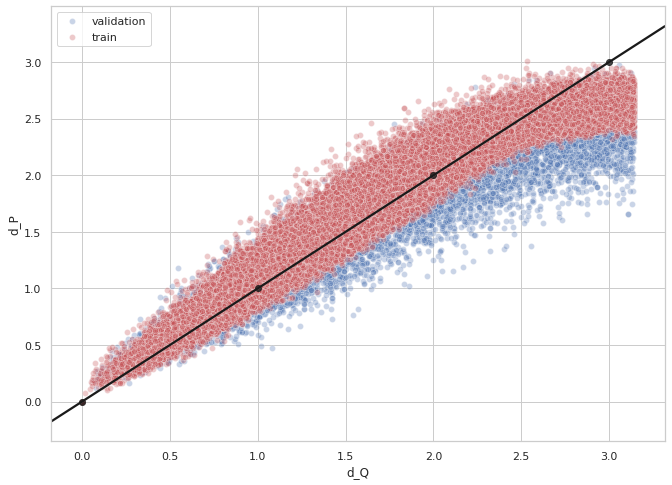

In [33]:
plt.clf();
fig, ax = plt.subplots(1, 1, figsize=(11,8));
sns.scatterplot(x="d_Q", y="d_P", data=df2, color="b", alpha=0.3, label="validation", ax=ax);  # "reg", "kde"
sns.scatterplot(x="d_Q", y="d_P", data=df1, color="r", alpha=0.3, label="train", ax=ax);  # "reg", "kde"
x = np.arange(0, np.pi);
sns.regplot(x=x, y=x, color="k", ax=ax);

In [34]:
from scipy.stats import linregress

lr = linregress(df1.d_Q, df1.d_P)
print(f"Train d_P/d_Q = {lr.slope}, intercept = {lr.intercept}")

lr = linregress(df2.d_Q, df2.d_P)
print(f"Validation d_P/d_Q = {lr.slope}, intercept = {lr.intercept}")

Train d_P/d_Q = 0.835995888695513, intercept = 0.32802713790783544
Validation d_P/d_Q = 0.7711191785114636, intercept = 0.352925783302509


In [35]:
slope, intercept = 1, 0

---

# 2. Angle Recovery (start with true angles)

In [36]:
num_pairs = 20000

###### Predicted Angles (initialization)

In [37]:
# low_ang = [float(x)*np.pi for x in angle_shift.split(",")]
# high_ang = [float(x)*np.pi for x in angle_ranges.split(",")]

# euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
#                           high=[high_ang[0], high_ang[1], high_ang[2]],
#                           size=(NUM_PROJECTIONS, 3))
euler = y

angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (0.0001, 6.2830)


(5000,)

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{\{i,j |d_p(p_i, p_j) < \epsilon\}} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [38]:
def loss(a1_predicted, a2_predicted, distance_target, dt_type, space):
    a1_predicted = list(a1_predicted)
    a2_predicted = list(a2_predicted)
    
    q1 = euler2quaternion(a1_predicted)
    q2 = euler2quaternion(a2_predicted)
    
    distance = d_q(q1, q2)
    
    if space == "dQspace":
        if dt_type == "dP":
            # Convert dP to dQ
            distance_target = (distance_target-intercept)/slope
            
    elif space == "dPspace":
        if dt_type == "dP":
            # Convert dQ to dP
            distance = tf.math.polyval(coeffs4dP, distance)
        elif dt_type == "dQ":
            distance = tf.math.polyval(coeffs4dP, distance)
            distance_target = tf.math.polyval(coeffs4dP, distance_target)  

    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [39]:
def gradient(a1_predicted, a2_predicted, distance_target, dt_type, space):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, dt_type, space)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

In [40]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False, angles_predicted=angles_predicted):
    losses = np.empty(steps)
    time_start = time()
    optimizer = Adam(learning_rate=0.001)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1, idx2 = sample_pairs(projections=test_idx, num_pairs=batch_size, style="random", k=k)
        
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [y[i] for i in idx1]
        a2_true = [y[i] for i in idx2]
        q1_true = euler2quaternion(a1_true)
        q2_true = euler2quaternion(a2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dQ", space="dQspace")
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dQ", space="dQspace")
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            #loss_mean = np.mean(losses[(step-1)-(steps//10):step-1])
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [41]:
def loss_predicted_angle_vs_projection(steps, batch_size, optimization=False, angles_predicted=angles_predicted):
    losses = np.empty(steps)
    time_start = time()
    optimizer = Adam(learning_rate=0.001)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1, idx2 = sample_pairs(projections=test_idx, num_pairs=batch_size, style="random", k=k)

        # Compute distances between projections
        p1 = [X[i] for i in idx1]
        p2 = [X[i] for i in idx2]

        distance_target = d_p(p1, p2)

        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # manual checkpoint
        angles_predicted_final = np.zeros((NUM_PROJECTIONS, 3))
        for i, ap in enumerate(angles_predicted):
            angles_predicted_final[i] = ap.numpy()

        np.save('data/angles_predicted_final.npy', angles_predicted_final)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dP", space="dQspace")
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dP", space="dQspace")

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')


    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [42]:
def d_p(p1, p2):
    p1 = np.array(p1)
    p1 = p1.reshape(list(p1.shape) + [-1])
    p2 = np.array(p2)
    p2 = p2.reshape(list(p2.shape) + [-1])
    return model.predict([p1, p2])

## Optimization loop (projection-true & angles-predict)

##### True Angles

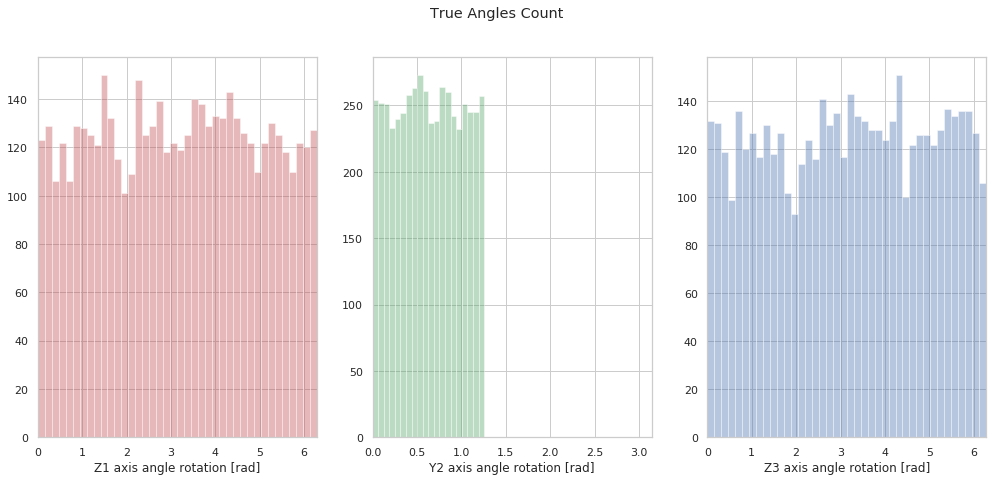

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(y[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(y[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(y[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [44]:
loss_predicted_angle_vs_projection(steps=500, batch_size=512, optimization=False, angles_predicted=angles_predicted)

step 50/500 (85s): loss = 9.18e-01
step 100/500 (169s): loss = 9.47e-01
step 150/500 (253s): loss = 1.00e+00
step 200/500 (338s): loss = 9.72e-01
step 250/500 (422s): loss = 8.87e-01
step 300/500 (507s): loss = 8.97e-01
step 350/500 (592s): loss = 9.37e-01
step 400/500 (678s): loss = 8.51e-01
step 450/500 (762s): loss = 9.65e-01
step 500/500 (847s): loss = 8.97e-01
Mean loss: 0.9344701028308775


---

##### Predicted Angles [INITIAL]

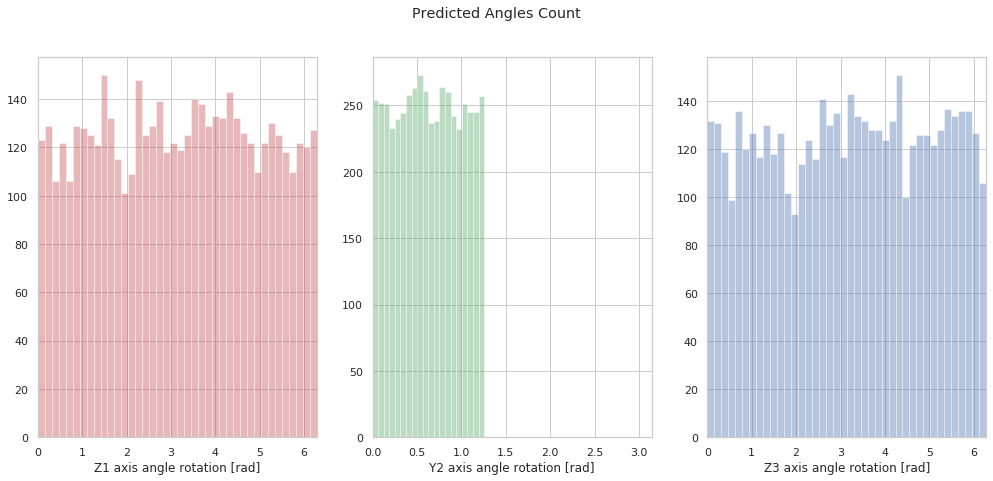

In [45]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [46]:
loss_predicted_vs_true_angle(steps=500, batch_size=256)

step 50/500 (4s): loss = 0.00e+00
step 100/500 (8s): loss = 0.00e+00
step 150/500 (11s): loss = 0.00e+00
step 200/500 (15s): loss = 0.00e+00
step 250/500 (18s): loss = 0.00e+00
step 300/500 (23s): loss = 0.00e+00
step 350/500 (27s): loss = 0.00e+00
step 400/500 (32s): loss = 0.00e+00
step 450/500 (36s): loss = 0.00e+00
step 500/500 (41s): loss = 0.00e+00
Mean loss: 0.0


step 500/5000 (958s): loss = 9.87e-01
step 1000/5000 (1908s): loss = 9.94e-01
step 1500/5000 (2859s): loss = 9.02e-01
step 2000/5000 (3802s): loss = 8.46e-01
step 2500/5000 (4749s): loss = 9.49e-01
step 3000/5000 (5714s): loss = 9.89e-01
step 3500/5000 (6673s): loss = 9.53e-01
step 4000/5000 (7641s): loss = 9.10e-01
step 4500/5000 (8612s): loss = 9.47e-01
step 5000/5000 (9564s): loss = 8.90e-01


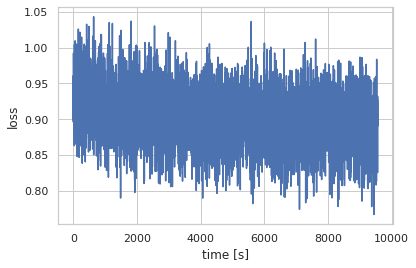

In [47]:
steps=5000
batch_size=512

loss_predicted_angle_vs_projection(steps, batch_size, optimization=True, angles_predicted=angles_predicted)

In [48]:
loss_predicted_vs_true_angle(steps=500, batch_size=256)

step 50/500 (4s): loss = 1.12e-01
step 100/500 (8s): loss = 1.17e-01
step 150/500 (12s): loss = 1.04e-01
step 200/500 (17s): loss = 1.19e-01
step 250/500 (21s): loss = 9.76e-02
step 300/500 (25s): loss = 1.17e-01
step 350/500 (30s): loss = 1.01e-01
step 400/500 (34s): loss = 9.65e-02
step 450/500 (37s): loss = 1.25e-01
step 500/500 (42s): loss = 1.02e-01
Mean loss: 0.11021007300457367


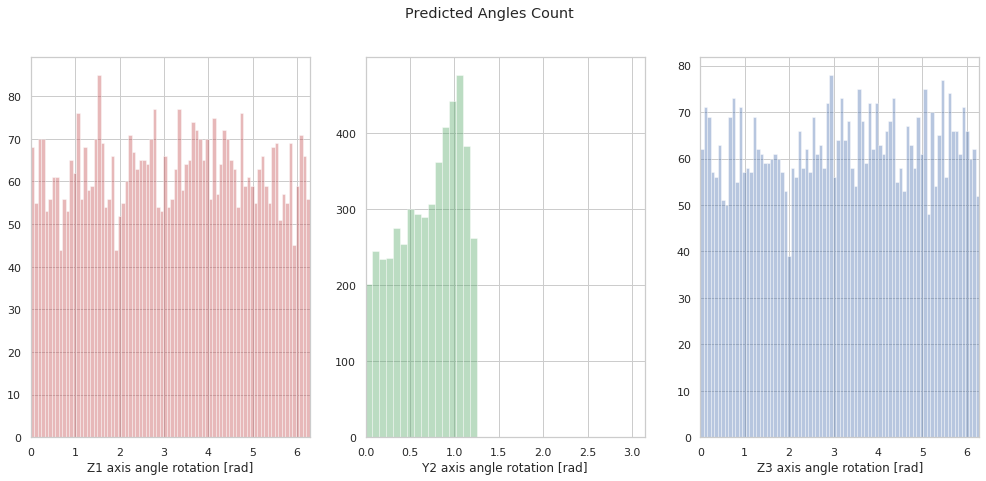

In [49]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=80, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=80, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [50]:
# plot
all_vectors = RotationMatrix(angles_predicted_plot)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
#ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()

In [48]:
# continue here

In [51]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])
angles_true_plot = y

all_vectors_p = RotationMatrix(angles_predicted_plot)
all_vectors_t = RotationMatrix(angles_true_plot)

In [52]:
limit=10

In [53]:
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors_p[:limit,0], all_vectors_p[:limit,2], all_vectors_p[:limit,1], marker="sphere", color="green", size=1)

for i in range(limit):
    connection0 = [all_vectors_p[i,0], all_vectors_t[i,0]]
    connection1 = [all_vectors_p[i,1], all_vectors_t[i,1]]
    connection2 = [all_vectors_p[i,2], all_vectors_t[i,2]]
    ipv.plot(connection0, connection2, connection1, marker="sphere", color="red", size=1)
    
ipv.scatter(all_vectors_t[:limit,0], all_vectors_t[:limit,2], all_vectors_t[:limit,1], marker="sphere", color="red", size=1)

ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()

# 3. Angle Estimation Error

The ideal metric is the mean average angle estimation error, under best alignment:
$$
\min_R \frac{1}{n} \sum_{i=1}^n \left| d_Q(Q_i, R \hat{Q}_i) \right|
$$

* $d_Q$ is the distance between two quaternions
* $Q_i$ is the true quaternion (angles, rotation)
* $\hat{Q}_i$ is the estimated quaternion (angles, rotation)
* $R$ is a quaternion representing a global rotation which best aligns the two sets of quaternions

The estimated quaternions are globally rotated as $R \hat{Q}_i$, where the multiplication (the [Hamilton product](https://en.wikipedia.org/wiki/Quaternion#Hamilton_product)) of two quaternions is the composition of the two rotations they represent.

@Jelena: you can implement it with gradient descent, in the same way we
do angle recovery. To be sure, that is the third optimization in the
pipeline (after angle recovery), whose sole purpose is to evaluate the
recovery.

Once aligned (i.e., the best R is found), plot both the true and aligned
recovered (predicted) quaternions on the same sphere. Add dashed lines
that link each true angle with the recovered one. That should make a
great visualization.

You can compute the metric and plot the visualization on the two
recovered angles you showed today.

In [24]:
# angles_predicted_final = np.zeros((NUM_PROJECTIONS, 3))
# for i, ap in enumerate(angles_predicted):
#     angles_predicted_final[i] = ap.numpy()

# np.save('data/angles_predicted_final_trueinit.npy', angles_predicted_final)

In [54]:
angles_predicted_final = np.load('data/angles_predicted_final_trueinit.npy')
angles_predicted = [e for e in angles_predicted_final]  # tf.Variable(e)

---

In [55]:
def lossR(a_R, a_predicted, a_true):
    a_predicted = list(a_predicted)
    a_true = list(a_true)
    
    q_predicted = euler2quaternion(a_predicted)
    q_true = euler2quaternion(a_true)
    q_R = euler2quaternion(a_R)

    distance = d_q(q_true, quaternion.multiply(q_R, q_predicted))
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(distance)

In [56]:
def gradientR(a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = lossR(a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient

In [57]:
euler = np.zeros(3, dtype=np.float64)
a_R = [tf.Variable(euler)]

In [58]:
print(f"rotation : {a_R[0].numpy()}\nloss     : {lossR(a_R, angles_predicted, y).numpy()}")

rotation : [0. 0. 0.]
loss     : 0.18667397215424347


In [59]:
loss_predicted_vs_true_angle(steps=500, batch_size=256)

step 50/500 (4s): loss = 1.07e-01
step 100/500 (9s): loss = 1.08e-01
step 150/500 (13s): loss = 1.07e-01
step 200/500 (17s): loss = 1.09e-01
step 250/500 (21s): loss = 1.05e-01
step 300/500 (26s): loss = 1.09e-01
step 350/500 (30s): loss = 1.23e-01
step 400/500 (34s): loss = 1.13e-01
step 450/500 (39s): loss = 1.13e-01
step 500/500 (42s): loss = 1.09e-01
Mean loss: 0.10953521764536843


step 2000/20000 (117s): loss = 1.95e-01
step 4000/20000 (234s): loss = 2.02e-01
step 6000/20000 (348s): loss = 1.97e-01
step 8000/20000 (464s): loss = 1.90e-01
step 10000/20000 (576s): loss = 1.83e-01
step 12000/20000 (689s): loss = 2.20e-01
step 14000/20000 (806s): loss = 1.86e-01
step 16000/20000 (922s): loss = 1.90e-01
step 18000/20000 (1038s): loss = 1.90e-01
step 20000/20000 (1155s): loss = 1.64e-01


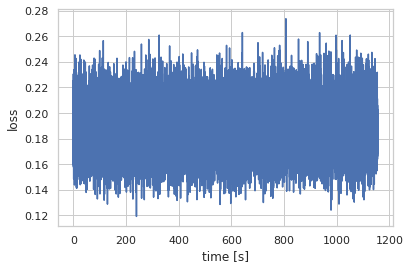

In [60]:
steps=20000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = Adam(learning_rate=0.01)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx = list(np.random.choice(NUM_PROJECTIONS, size=batch_size))
    
    # Compute distances between projections
    a_true = [y[i] for i in idx]
    a_predicted = [angles_predicted[i] for i in idx]
    
    # Optimize by gradient descent.
    losses[step-1], gradients = gradientR(a_R, a_predicted, a_true)
    optimizer.apply_gradients(zip(gradients, a_R))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

In [61]:
print(f"rotation : {a_R[0].numpy()}\nloss     : {lossR(a_R, angles_predicted, y).numpy()}")

rotation : [ 0.00031221 -0.00193574  0.00033048]
loss     : 0.18804932281373327


we have: 1.85 rad = 105 deg

we want: 10 deg = 0.17 rad

In [62]:
# rotate to get new angles
q_predicted = euler2quaternion(angles_predicted)
q_R = euler2quaternion(a_R)
q_predicted_new = quaternion.multiply(q_predicted, q_R)

angles_predicted_new = quaternion2euler(q_predicted_new)

##### true vs. predicted vs.rotated prediction

In [65]:
i = 0
y[i], angles_predicted[i], angles_predicted_new[i].numpy()

(array([3.11525987, 1.10904451, 3.23112903]),
 array([3.11525987, 1.10904451, 3.23112903]),
 array([ 3.11545369,  1.11097244, -3.05149976]))

In [66]:
angles_predicted_plot_new = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted_new])
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x]) for x in angles_predicted])
angles_true_plot = y

all_vectors_p_new = RotationMatrix(angles_predicted_plot_new)
all_vectors_p = RotationMatrix(angles_predicted_plot)
all_vectors_t = RotationMatrix(angles_true_plot)

limit=10

# plot
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)

ipv.scatter(all_vectors_p[:limit,0], all_vectors_p[:limit,2], all_vectors_p[:limit,1], marker="sphere", color="blue", size=1)

for i in range(limit):
    connection0 = [all_vectors_p[i,0], all_vectors_p_new[i,0]]
    connection1 = [all_vectors_p[i,1], all_vectors_p_new[i,1]]
    connection2 = [all_vectors_p[i,2], all_vectors_p_new[i,2]]
    ipv.plot(connection0, connection2, connection1,color="green", lynestyle="--")

ipv.scatter(all_vectors_p_new[:limit,0], all_vectors_p_new[:limit,2], all_vectors_p_new[:limit,1], marker="sphere", color="green", size=1)

for i in range(limit):
    connection0 = [all_vectors_p_new[i,0], all_vectors_t[i,0]]
    connection1 = [all_vectors_p_new[i,1], all_vectors_t[i,1]]
    connection2 = [all_vectors_p_new[i,2], all_vectors_t[i,2]]
    ipv.plot(connection0, connection2, connection1, marker="sphere", color="red", size=1)

ipv.scatter(all_vectors_t[:limit,0], all_vectors_t[:limit,2], all_vectors_t[:limit,1], marker="sphere", color="red", size=1)

ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()


In [67]:
loss_predicted_vs_true_angle(steps=500, batch_size=256, angles_predicted=angles_predicted_new)

step 50/500 (5s): loss = 3.35e-01
step 100/500 (11s): loss = 3.26e-01
step 150/500 (16s): loss = 3.40e-01
step 200/500 (21s): loss = 2.82e-01
step 250/500 (27s): loss = 3.00e-01
step 300/500 (32s): loss = 3.20e-01
step 350/500 (37s): loss = 3.47e-01
step 400/500 (43s): loss = 3.04e-01
step 450/500 (48s): loss = 3.72e-01
step 500/500 (53s): loss = 2.85e-01
Mean loss: 0.3207580284755362
